In [2]:
## use autogluon for multimodal regression
# !pip install -U pip
# !pip install -U setuptools wheel
# !pip install autogluon

In [2]:
## 直接读取原始数据，并且保留原来的文本和图像，并把tag和title拼接
import random
import os
import re
import json
import numpy as np
import pandas as pd
import lightgbm as lgbm
from datetime import datetime
from time import gmtime, strftime
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import torch
import lightgbm
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error
random_seed = 2020
random.seed(random_seed)
np.random.seed(random_seed)

In [30]:
all_data = pd.read_csv('../data/forauto.csv')
cate_cols = ['Uid', 'Category', 'Subcategory', 'Concept', 'Mediatype', 'hour', 'day', 'weekday', 'week_hour', 'year_weekday','Geoaccuracy', 'ispro' , 'Ispublic']
all_data[cate_cols] = all_data[cate_cols].astype("category")
train_all_data = all_data[:-180581]
submit_all_data = all_data[-180581:]
all_data

,Uid,Uid_count,Category,Subcategory,Concept,Title_len,Title_number,Alltags_len,Alltags_number,img_length,...,followerCount,followingCount,Ispublic,label,img_file,Category.1,Concept.1,Subcategory.1,Alltags,Title
0,21894,4,5,65,75,33,6,128,12,333,...,2405,2729,1,11.18,train/59@N75/775.jpg,Fashion,glam,Fashion,rock punk transgender tranny electronicmusic e...,Luis Drayton - Edinburgh shoot #6
1,53866,13,0,75,139,56,13,800,65,500,...,8491,236,1,15.15,train/1@N18/1075.jpg,Travel&Active&Sports,fifa,Soccer,brazil rio brasil riodejaneiro by maria fifa m...,Arena da Barra - Arena HSBC - Arena do PAN #...
2,26948,1,3,42,480,12,2,188,23,500,...,1550,1346,1,10.99,train/351@N64/4890.jpg,Entertainment,cinema,Movies,old cinema beauty marilyn photoshop movie joke...,MARILYN 2015
3,355,1,10,68,225,18,3,61,9,500,...,1233,1115,1,8.63,train/6@N59/6568.jpg,Holiday&Celebrations,old,Birthday,pictures old family scans brothers sister 1958...,Knikkertijd - 1959
4,315,31,2,43,317,8,1,146,19,500,...,5781,13,1,11.16,train/1617@N40/7079.jpg,Food,thirsty,Drinks,hot sahara animal animals desert bottles drink...,CAMELS01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486189,46088,2,0,35,301,6,1,78,13,500,...,489,612,1,0.00,test/49686@N77/1118324.jpg,Travel&Active&Sports,sea,Seattle,natur nature frog sea lake fish outdoor macro ...,Quaak!
486190,12280,7,0,60,110,25,4,164,23,500,...,0,0,1,0.00,test/31147@N75/1118329.jpg,Travel&Active&Sports,cars,Cars,11 arisk okruh veternov 2016 10 jn preov veter...,arisk okruh veternov 2016
486191,43496,9,4,28,186,41,7,85,9,500,...,702,113,1,0.00,test/5656@N26/1118336.jpg,Animal,cat,Cats,holland netherlands amsterdam cat nl ramses gu...,Bike & Cat / Eerste Anjeliers Dwarsstraat
486192,5492,17,7,27,54,15,3,305,35,500,...,1092,389,1,0.00,test/28302@N36/1118349.jpg,Whether&Season,white,Snowing,street people bw white black netherlands monoc...,The Stairs crew


In [5]:
list(submit_all_data['label']).count(0)

180581

In [31]:
label = 'label'
image_col = 'img_file'

In [32]:
dataset_path = '/MMChallenge/SMP/data'

In [33]:
def path_expander(path, base_folder):
    path_l = path.split(';')
    return ';'.join([os.path.abspath(os.path.join(base_folder, path)) for path in path_l])

train_all_data[image_col] = train_all_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
submit_all_data[image_col] = submit_all_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))

train_all_data[image_col].iloc[0]

/tmp/ipykernel_673597/1922593402.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_all_data[image_col] = train_all_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
/tmp/ipykernel_673597/1922593402.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit_all_data[image_col] = submit_all_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))


'/MMChallenge/SMP/data/train/59@N75/775.jpg'

In [34]:
example_row = train_all_data.iloc[1]

example_row

Uid                                                          53866
Uid_count                                                       13
Category                                                         0
Subcategory                                                     75
Concept                                                        139
                                       ...                        
Category.1                                    Travel&Active&Sports
Concept.1                                                     fifa
Subcategory.1                                               Soccer
Alltags          brazil rio brasil riodejaneiro by maria fifa m...
Title            Arena da Barra - Arena HSBC - Arena do PAN   #...
Name: 1, Length: 89, dtype: object

In [35]:
example_row['Alltags']

'brazil rio brasil riodejaneiro by maria fifa military games arena da pan claudio barra 2007 futsal olympicgames lenk claudiolara aqutico copabacana sunsetinrio militaryworldgames brasll brazll estdioolmpicojoohavelange praiasdorio unitedkingdomofengenhodedentro rio2016 clcrio clcbr amanhecernorio claudiol avembaixadorabelardobueno clccam olimpadasmilitares mundialmilitarrio2011 claudiorio atraes carnivalbyclaudio claudoil engenhobyclaudio estdioolmpicojoohavelangebyclaudio barradatijucabyclaudio carnavalbyclaudio rio450 rio450anos flickrbyclaudio claudioarena lapabyclaudio rio2016byclaudio brasil2014byclaudio rio2014byclaudio brazil2014byclaudio csim2011 claudioparque hsbcbyclaudio claudiomundial rlodejaneiro rlodejanelro claudiobatman ciadedorio sunrisainrio braekingdawninrio parambulando'

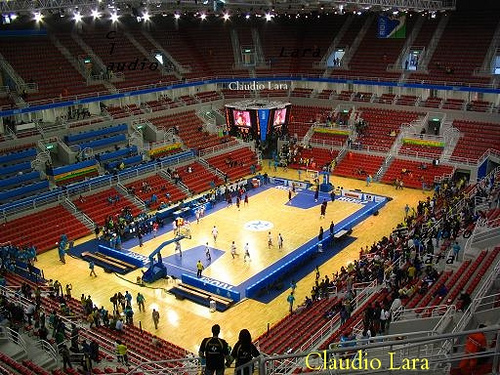

In [36]:
example_image = example_row['img_file']

from IPython.display import Image, display
pil_img = Image(filename=example_image)
display(pil_img)

In [37]:
from autogluon.tabular import FeatureMetadata
feature_metadata = FeatureMetadata.from_df(train_all_data)

print(feature_metadata)

('category', [])     : 13 | ['Uid', 'Category', 'Subcategory', 'Concept', 'Mediatype', ...]
('float', [])        : 46 | ['svd_mode_t_0', 'svd_mode_t_1', 'svd_mode_t_2', 'svd_mode_t_3', 'svd_mode_t_4', ...]
('int', [])          : 24 | ['Uid_count', 'Title_len', 'Title_number', 'Alltags_len', 'Alltags_number', ...]
('object', [])       :  4 | ['img_file', 'Category.1', 'Concept.1', 'Subcategory.1']
('object', ['text']) :  2 | ['Alltags', 'Title']


In [38]:
feature_metadata = feature_metadata.add_special_types({image_col: ['image_path']})

print(feature_metadata)

('category', [])           : 13 | ['Uid', 'Category', 'Subcategory', 'Concept', 'Mediatype', ...]
('float', [])              : 46 | ['svd_mode_t_0', 'svd_mode_t_1', 'svd_mode_t_2', 'svd_mode_t_3', 'svd_mode_t_4', ...]
('int', [])                : 24 | ['Uid_count', 'Title_len', 'Title_number', 'Alltags_len', 'Alltags_number', ...]
('object', [])             :  3 | ['Category.1', 'Concept.1', 'Subcategory.1']
('object', ['image_path']) :  1 | ['img_file']
('object', ['text'])       :  2 | ['Alltags', 'Title']


In [39]:
from autogluon.tabular.configs.hyperparameter_configs import get_hyperparameter_config
hyperparameters = get_hyperparameter_config('multimodal')

hyperparameters

{'NN_TORCH': {},
 'GBM': [{},
  {'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}},
  'GBMLarge'],
 'CAT': {},
 'XGB': {},
 'AG_AUTOMM': {},
 'VW': {}}

In [40]:
from autogluon.tabular import TabularPredictor
excluded_model_types = ['GBM']
predictor = TabularPredictor(label=label).fit(
    train_data=train_all_data,
    hyperparameters=hyperparameters,
    excluded_model_types=excluded_model_types,
    feature_metadata=feature_metadata,
    # num_bag_folds=5, 
    ag_args_fit={'num_gpus': 4}
    # hyperparameters = {'NN_TORCH': {'num_epochs': 5}, 'GBM': {'num_boost_round': 20}},
)

No path specified. Models will be saved in: "AutogluonModels/ag-20230527_132929/"
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230527_132929/"
AutoGluon Version:  0.7.0
Python Version:     3.8.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #78~20.04.1-Ubuntu SMP Wed Apr 19 11:26:48 UTC 2023
Train Data Rows:    305613
Train Data Columns: 88
Label Column: label
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (16.56, 1.0, 6.40552, 2.47301)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may s

In [41]:
all_models = predictor.get_model_names()
all_models

['CatBoost',
 'XGBoost',
 'NeuralNetTorch',
 'VowpalWabbit',
 'MultiModalPredictor',
 'WeightedEnsemble_L2']

In [42]:
i = 0  # index of model to use
model_to_use = predictor.get_model_names()[i]
model_pred0 = predictor.predict(submit_all_data.drop(columns=[label]), model=model_to_use)
print("Prediction from %s model: %s" % (model_to_use, model_pred0.iloc[0]))

Prediction from CatBoost model: 9.186755


In [43]:
i = 1  # index of model to use
model_to_use = predictor.get_model_names()[i]
model_pred1 = predictor.predict(submit_all_data.drop(columns=[label]), model=model_to_use)
print("Prediction from %s model: %s" % (model_to_use, model_pred1.iloc[0]))

/usr/local/lib/python3.8/dist-packages/pandas/core/arrays/base.py:513: RuntimeWarning: invalid value encountered in cast
  result = np.asarray(self, dtype=dtype)


Prediction from XGBoost model: 9.790573


In [44]:
i = 2  # index of model to use
model_to_use = predictor.get_model_names()[i]
model_pred2 = predictor.predict(submit_all_data.drop(columns=[label]), model=model_to_use)
print("Prediction from %s model: %s" % (model_to_use, model_pred2.iloc[0]))

/usr/local/lib/python3.8/dist-packages/pandas/core/arrays/base.py:513: RuntimeWarning: invalid value encountered in cast
  result = np.asarray(self, dtype=dtype)
/usr/local/lib/python3.8/dist-packages/pandas/core/arrays/base.py:513: RuntimeWarning: invalid value encountered in cast
  result = np.asarray(self, dtype=dtype)


Prediction from NeuralNetTorch model: 7.6579366


In [45]:
i = 3  # index of model to use
model_to_use = predictor.get_model_names()[i]
model_pred3 = predictor.predict(submit_all_data.drop(columns=[label]), model=model_to_use)
print("Prediction from %s model: %s" % (model_to_use, model_pred3.iloc[0]))

Prediction from VowpalWabbit model: 9.459954


In [46]:
i = 4  # index of model to use
model_to_use = predictor.get_model_names()[i]
model_pred4 = predictor.predict(submit_all_data.drop(columns=[label]), model=model_to_use)
print("Prediction from %s model: %s" % (model_to_use, model_pred4.iloc[0]))

loading file vocab.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading configuration file /MMChallenge/SMP/HyFea-main/AutogluonModels/ag-20230527_132929/models/MultiModalPredictor/automm_model/hf_text/config.json
Model config ElectraConfig {
  "_name_or_path": "/MMChallenge/SMP/HyFea-main/AutogluonModels/ag-20230527_132929/models/MultiModalPredictor/automm_model/hf_text",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_las

Prediction from MultiModalPredictor model: 9.7533455


In [48]:
i = 5  # index of model to use
model_to_use = predictor.get_model_names()[i]
model_pred5 = predictor.predict(submit_all_data.drop(columns=[label]), model=model_to_use)
print("Prediction from %s model: %s" % (model_to_use, model_pred5.iloc[0]))

loading file vocab.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading configuration file /MMChallenge/SMP/HyFea-main/AutogluonModels/ag-20230527_132929/models/MultiModalPredictor/automm_model/hf_text/config.json
Model config ElectraConfig {
  "_name_or_path": "/MMChallenge/SMP/HyFea-main/AutogluonModels/ag-20230527_132929/models/MultiModalPredictor/automm_model/hf_text",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_las

Prediction from WeightedEnsemble_L2 model: 9.533422


In [49]:
model_pred0.to_csv('../data/auto_CAallfea_CAT.csv',header=True, index=None)
model_pred1.to_csv('../data/auto_CAallfea_XGB.csv',header=True, index=None)
model_pred2.to_csv('../data/auto_CAallfea_NNT.csv',header=True, index=None)
model_pred3.to_csv('../data/auto_CAallfea_VW.csv',header=True, index=None)
model_pred4.to_csv('../data/auto_CAallfea_MMP.csv',header=True, index=None)
model_pred5.to_csv('../data/auto_CAallfea_Ensemble.csv',header=True, index=None)
# model_pred0.to_csv('../data/auto_allfea_5models.csv',header=True, index=None)

In [18]:
y_pred = predictor.predict(submit_all_data.drop(columns=[label]))
y_pred.head()

loading file vocab.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading configuration file /MMChallenge/SMP/HyFea-main/AutogluonModels/ag-20230526_094844/models/MultiModalPredictor/automm_model/hf_text/config.json
Model config ElectraConfig {
  "_name_or_path": "/MMChallenge/SMP/HyFea-main/AutogluonModels/ag-20230526_094844/models/MultiModalPredictor/automm_model/hf_text",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_las

305613    9.867780
305614    9.572746
305615    9.750528
305616    6.719084
305617    6.767485
Name: label, dtype: float32

In [50]:
leaderboard = predictor.leaderboard(submit_all_data)

/usr/local/lib/python3.8/dist-packages/pandas/core/arrays/base.py:513: RuntimeWarning: invalid value encountered in cast
  result = np.asarray(self, dtype=dtype)
/usr/local/lib/python3.8/dist-packages/pandas/core/arrays/base.py:513: RuntimeWarning: invalid value encountered in cast
  result = np.asarray(self, dtype=dtype)
/usr/local/lib/python3.8/dist-packages/pandas/core/arrays/base.py:513: RuntimeWarning: invalid value encountered in cast
  result = np.asarray(self, dtype=dtype)
loading file vocab.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading configuration file /MMChallenge/SMP/HyFea-main/AutogluonModels/ag-20230527_132929/models/MultiModalPredictor/automm_model/hf_text/config.json
Model config ElectraConfig {
  "_name_or_path": "/MMChallenge/SMP/HyFea-main/AutogluonModels/ag-20230527_132929/models/MultiModalPredictor/automm_model/hf_text",
  "architectures": [
    "ElectraForPreTraining"

                 model  score_test  score_val  pred_time_test  pred_time_val      fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0         VowpalWabbit   -6.224528  -1.524063       55.026109       0.740438    291.251889                55.026109                0.740438         291.251889            1       True          4
1  MultiModalPredictor   -6.398814  -0.918519      886.406637      25.699481  66663.489773               886.406637               25.699481       66663.489773            1       True          5
2  WeightedEnsemble_L2   -6.465763  -0.801782     1025.783618      27.366637  68393.921299                 0.029652                0.000813           0.215681            2       True          6
3              XGBoost   -6.540148  -0.888550       67.029151       0.622470    242.537141                67.029151                0.622470         242.537141            1       True          2
4             CatBoost   -6.58

In [20]:
y_pred.to_csv('../data/auto_allfea_5models.csv',header=True, index=None)

In [25]:
np.mean(y_pred)

6.4557304

In [26]:
y_pred

305613     7.862693
305614    10.703367
305615    10.441699
305616     7.996438
305617     7.996438
            ...    
486189     7.990771
486190     7.232592
486191     8.485457
486192     9.426772
486193     7.799127
Name: label, Length: 180581, dtype: float32

In [27]:
y_pred.to_csv('../data/auto6455.csv',header=True, index=None)